In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
import matplotlib.patches as mpatches

## Loading the dataset

In [2]:
Xtrain_main = rasterio.open('Xtrain.tif').read()
Ytrain_main = rasterio.open('Ytrain.tif').read()
Xtest_main = rasterio.open('Xtest.tif').read()
Ytest_main = rasterio.open('Ytest_v2.tif').read()

In [3]:
print("shape of Xtrain: ", Xtrain_main.shape)
print("shape of Ytrain: ", Ytrain_main.shape)
print("shape of Xtest: ", Xtest_main.shape)
print("shape of Ytest: ", Ytest_main.shape)  #need to remake the dataset

shape of Xtrain:  (4, 1953, 2161)
shape of Ytrain:  (1, 1953, 2161)
shape of Xtest:  (4, 461, 490)
shape of Ytest:  (1, 461, 490)


/tmp/ipykernel_271/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


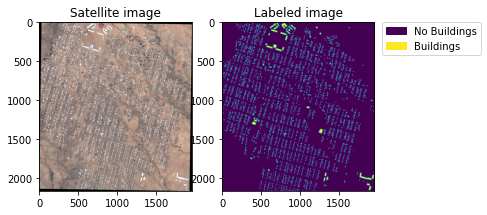

In [4]:
#Visualize the data

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["No Buildings", "Buildings"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(Xtrain_main.swapaxes(0,2),Ytrain_main.swapaxes(0,2)) #Visualize Images Side by Side

## Image Patching

Instead of random patching, here we are creating patches from entire dataset as we lack enough dataset.

In [5]:
PATCHSIZE = 128
NBANDS = Xtrain_main.shape[0]

def gridwise_sample(imgarray, patchsize):
    ''' to make a grid of 256x256 on top of the image and create sample patches '''
    nbands,nrows, ncols = imgarray.shape
    patchsamples = np.zeros(shape=(0, nbands,patchsize, patchsize),
                            dtype=imgarray.dtype)
    
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[:,i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

In [6]:
Xtrain = gridwise_sample(Xtrain_main, PATCHSIZE)
Ytrain = gridwise_sample(Ytrain_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 240 number of training patches


## Augmentation
Since there are fewer number of samples lets do the augmentation on Flip and Mirror

In [7]:
Xtrain_fliped = Xtrain[:,:,::-1, :]
Xtrain_mirrored = Xtrain[:,:,:,::-1]
Ytrain_fliped = Ytrain[:,:,::-1, :]
Ytrain_mirrored = Ytrain[:,:,:,::-1]

In [8]:
Xtrain.shape,Ytrain.shape

((240, 4, 128, 128), (240, 1, 128, 128))

/tmp/ipykernel_271/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


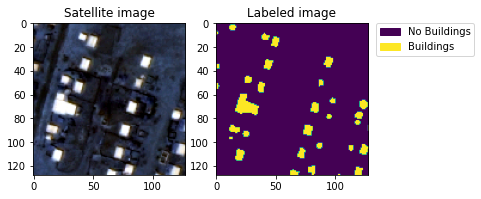

In [9]:
visualize_data(Xtrain[40].swapaxes(0,2),Ytrain[40].swapaxes(0,2))

/tmp/ipykernel_271/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


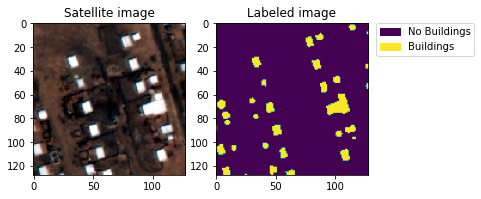

In [10]:
visualize_data(Xtrain_fliped[40].swapaxes(0,2),Ytrain_fliped[40].swapaxes(0,2))

/tmp/ipykernel_271/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


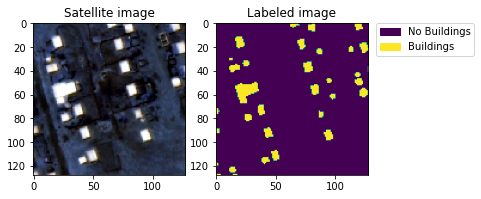

In [11]:
visualize_data(Xtrain_mirrored[40].swapaxes(0,2),Ytrain_mirrored[40].swapaxes(0,2))

In [12]:
#Lets append the datasets
Xtrain_fliped=np.append(Xtrain,Xtrain_fliped,axis=0)
Xtrain=np.append(Xtrain_fliped,Xtrain_mirrored,axis=0)
Ytrain_fliped=np.append(Ytrain,Ytrain_fliped,axis=0)
Ytrain=np.append(Ytrain_fliped,Ytrain_mirrored,axis=0)

In [13]:
Ytrain.shape

(720, 1, 128, 128)

## One hot Encoding
The Ytrain dataset only have 1 band which includes 0 for no buildings and 1 for buildings, so lets make it one hot encoding. In this case we will have to change 0 to [1,0] and 1 to [0,1]

In [14]:
ones=np.ones(Ytrain.shape)
ytrain_inverted=ones-Ytrain # Because 1-0 is 1 and 1-0 is zero
Ytrain=np.concatenate((ytrain_inverted,Ytrain),axis=1)
Ytrain.shape

(720, 2, 128, 128)

## convert to pytorch dataset
Lets convert the numpy array to pytorch datset

In [15]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(Xtrain) 
tensor_y = torch.Tensor(Ytrain)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
train_data = DataLoader(tensor_dataset) 

## Define the network
Lets define the famous UNET model for segmentation of buildings. The model is modified from https://github.com/milesial/Pytorch-UNet The Architecture of UNET is like this:
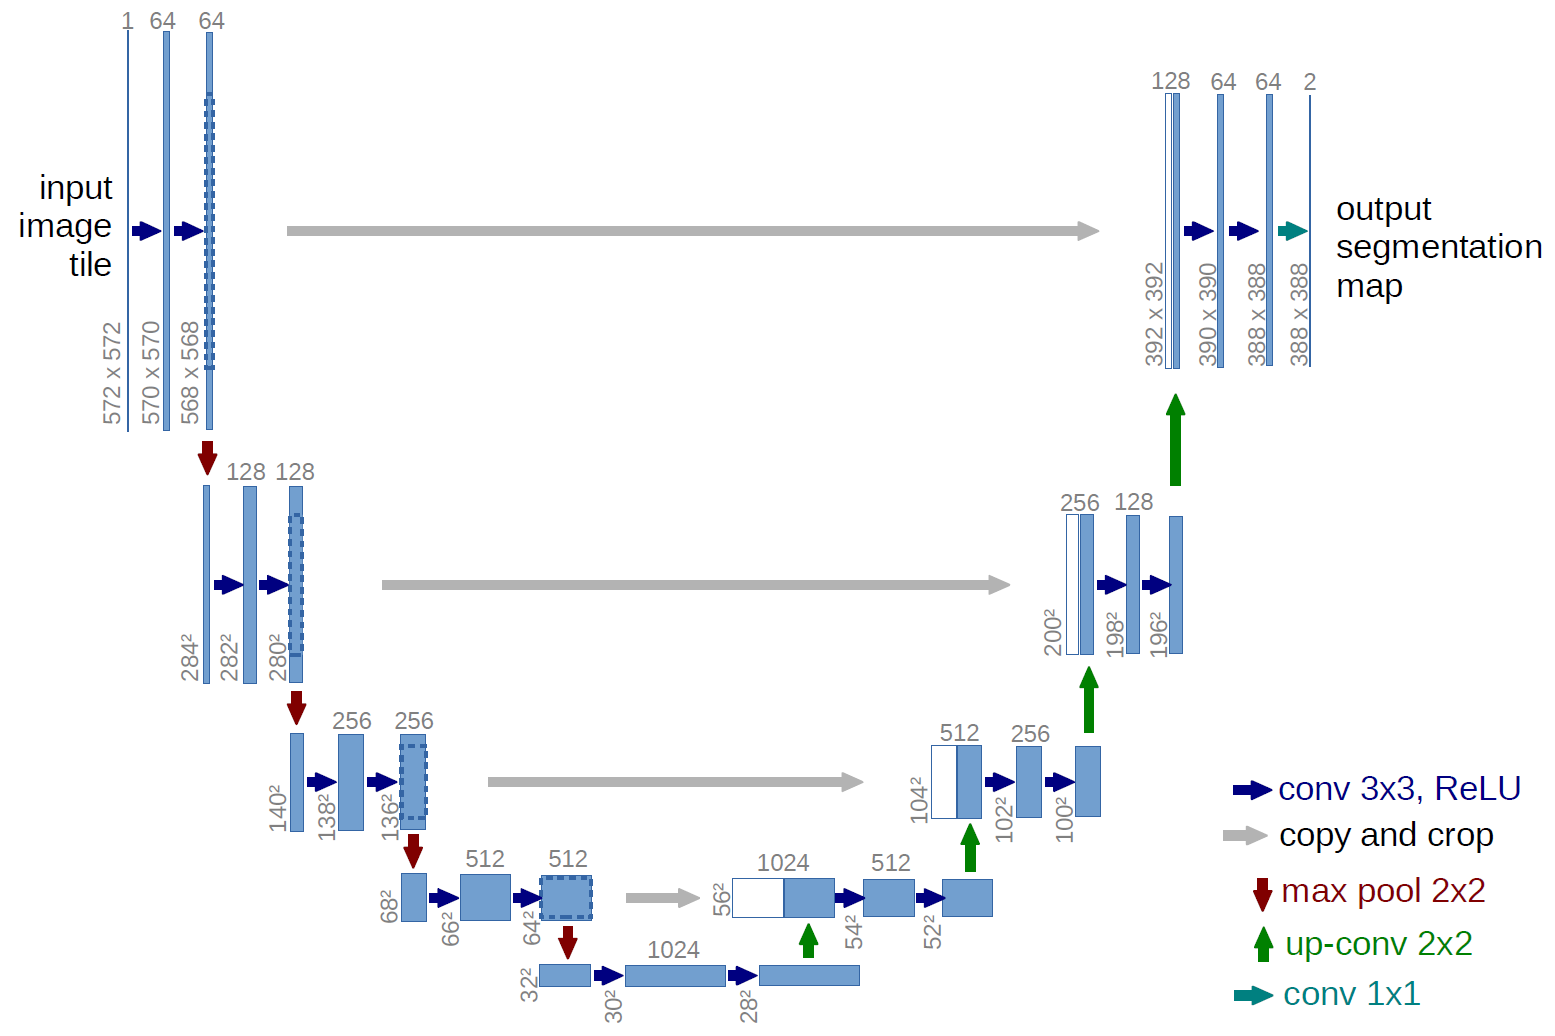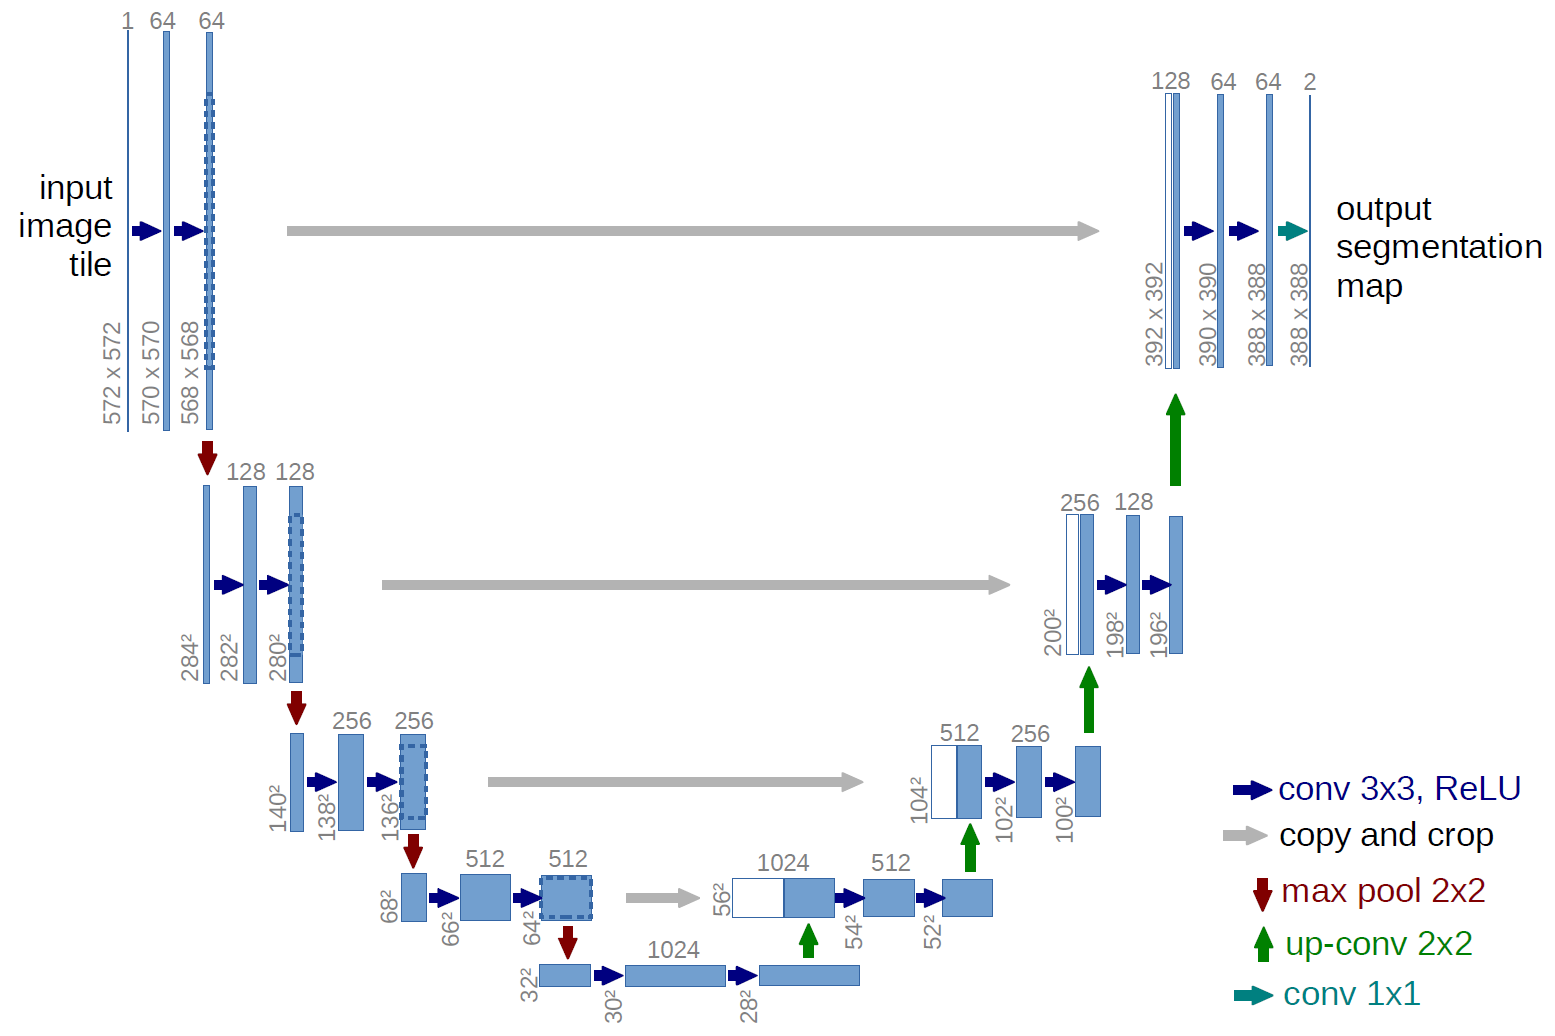

In [16]:
""" Defining Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [17]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [18]:
net = UNet(n_channels=4, n_classes=2, bilinear=True)
net.cuda()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [19]:
from torchsummary import summary
summary(net,input_size=( 4,128, 128),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 128, 128]           2,304
       BatchNorm2d-2          [1, 64, 128, 128]             128
              ReLU-3          [1, 64, 128, 128]               0
            Conv2d-4          [1, 64, 128, 128]          36,864
       BatchNorm2d-5          [1, 64, 128, 128]             128
              ReLU-6          [1, 64, 128, 128]               0
        DoubleConv-7          [1, 64, 128, 128]               0
         MaxPool2d-8            [1, 64, 64, 64]               0
            Conv2d-9           [1, 128, 64, 64]          73,728
      BatchNorm2d-10           [1, 128, 64, 64]             256
             ReLU-11           [1, 128, 64, 64]               0
           Conv2d-12           [1, 128, 64, 64]         147,456
      BatchNorm2d-13           [1, 128, 64, 64]             256
             ReLU-14           [1, 128,

## Design the optimizer

In [20]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

In [21]:
from IPython.display import clear_output
def train(net, optimizer, epochs, scheduler=None, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    running_loss = 0.
    last_loss = 0.
    loss_fn=torch.nn.CrossEntropyLoss()
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        
        
        for batch_idx, (data,target) in enumerate(train_data):
            data,target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            #print(inputs.cpu().numpy().shape)
            output = net(data)
            
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
        
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = np.argmax(target.data.cpu().numpy()[0],axis=0)
                print(pred.shape,gt.shape)
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_data),
                    100. * batch_idx / len(train_data), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(gt)
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(pred)
                plt.show()
            iter_ += 1

            del(data, target, loss)
    torch.save(net.state_dict(), './unet_final')


(128, 128) (128, 128)
Train (epoch 5/5) [620/720 (86%)]	Loss: 0.064966	Accuracy: 97.735595703125


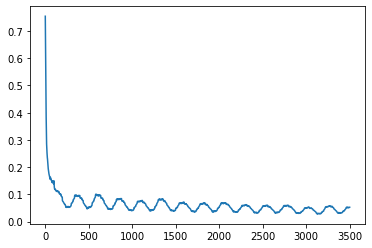

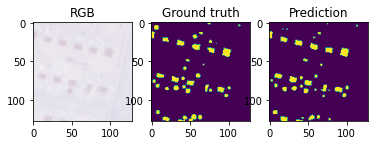

In [22]:
train(net, optimizer, 5, scheduler)

# TEST


## Prepare Test Data

/tmp/ipykernel_271/71467182.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


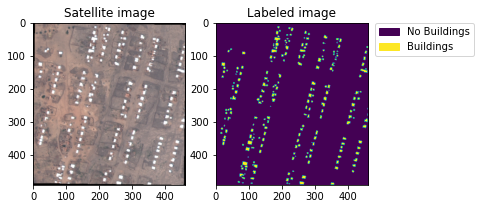

In [23]:
#Visualize the data
visualize_data(Xtest_main.swapaxes(0,2),Ytest_main.swapaxes(0,2)) #Visualize Images Side by Side

In [24]:
#creating test dataset patches
Xtest = gridwise_sample(Xtest_main, PATCHSIZE)
Ytest = gridwise_sample(Ytest_main, PATCHSIZE)
print("There are %i number of training patches" % (Xtest.shape[0]))

There are 9 number of training patches


In [25]:
#one hot encoding on test dataset
ones=np.ones(Ytest.shape)
ytest_inverted=ones-Ytest # Because 1-0 is 1 and 1-0 is zero
Ytest=np.concatenate((ytest_inverted,Ytest),axis=1)
Ytest.shape

(9, 2, 128, 128)

In [26]:
#converting to tensor
tensor_x = torch.Tensor(Xtest) 
tensor_y = torch.Tensor(Ytest)

tensor_dataset = TensorDataset(tensor_x,tensor_y) 
test_data = DataLoader(tensor_dataset) 

In [27]:
# Utils
LABELS=['No Buildings','Buildings']

from sklearn.metrics import confusion_matrix

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            labels=range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [28]:
def test():
    all_preds = []
    all_gts = []
    all_acs=[]
    net.eval()
    for test_idx, (data,target) in enumerate(test_data):
        print(f'--------------Testing on patch number: {test_idx+1}----------------- ')
        data,target = Variable(data.cuda()), Variable(target.cuda())
        output = net(data)

        pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
        gt = np.argmax(target.data.cpu().numpy()[0],axis=0)

        # Display the result
        rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
        fig = plt.figure()
        fig.add_subplot(131)
        plt.imshow(rgb)
        plt.title('RGB')
        fig.add_subplot(132)
        plt.imshow(gt)
        plt.title('Ground truth')
        fig.add_subplot(133)
        plt.title('Prediction')
        plt.imshow(pred)
        plt.show()
        all_preds.append(pred)
        all_gts.append(gt)
        #return pred.ravel(),gt_e.ravel()
        # Compute some metrics
        metrics(pred.ravel(), gt.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
        all_acs.append(accuracy)
    print(f'--------------Overall Accuracy: ----------------- ')
    print(f'Mean accuracy in test set is: {sum(all_acs) / len(all_acs)}')
    return all_acs

--------------Testing on patch number: 1----------------- 


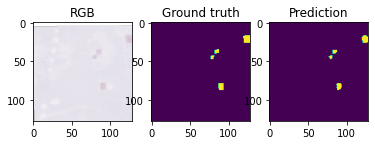

Confusion matrix :
[[16187     3]
 [   31   163]]
---
16384 pixels processed
Total accuracy : 99.79248046875%
---
F1Score :
No Buildings: 0.9989508763268329
Buildings: 0.9055555555555556
---
Kappa: 0.9045128485016367
Confusion matrix :
[[16187     3]
 [   31   163]]
---
16384 pixels processed
Total accuracy : 99.79248046875%
---
F1Score :
No Buildings: 0.9989508763268329
Buildings: 0.9055555555555556
---
Kappa: 0.9045128485016367
--------------Testing on patch number: 2----------------- 


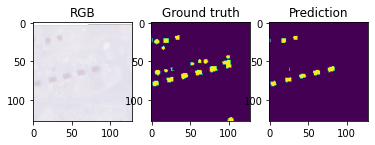

Confusion matrix :
[[15699     0]
 [  377   308]]
---
16384 pixels processed
Total accuracy : 97.698974609375%
---
F1Score :
No Buildings: 0.9881353265145555
Buildings: 0.6203423967774421
---
Kappa: 0.6102334320585546
Confusion matrix :
[[31886     3]
 [  408   471]]
---
32768 pixels processed
Total accuracy : 98.7457275390625%
---
F1Score :
No Buildings: 0.9935964351931197
Buildings: 0.6962305986696231
---
Kappa: 0.6904117925018848
--------------Testing on patch number: 3----------------- 


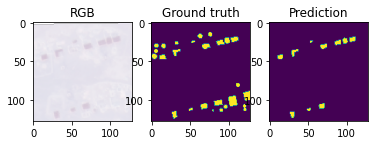

Confusion matrix :
[[15376     6]
 [  643   359]]
---
16384 pixels processed
Total accuracy : 96.038818359375%
---
F1Score :
No Buildings: 0.9793318684118341
Buildings: 0.5252377468910022
---
Kappa: 0.5092090325489391
Confusion matrix :
[[47262     9]
 [ 1051   830]]
---
49152 pixels processed
Total accuracy : 97.84342447916667%
---
F1Score :
No Buildings: 0.9889102778707733
Buildings: 0.6102941176470589
---
Kappa: 0.6008712372255294
--------------Testing on patch number: 4----------------- 


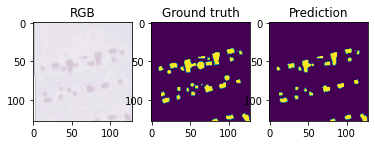

Confusion matrix :
[[15200    20]
 [  342   822]]
---
16384 pixels processed
Total accuracy : 97.79052734375%
---
F1Score :
No Buildings: 0.9882322345751251
Buildings: 0.8195413758723828
---
Kappa: 0.8080960513720774
Confusion matrix :
[[62462    29]
 [ 1393  1652]]
---
65536 pixels processed
Total accuracy : 97.8302001953125%
---
F1Score :
No Buildings: 0.9887451917749671
Buildings: 0.6991112991959374
---
Kappa: 0.6888260555725896
--------------Testing on patch number: 5----------------- 


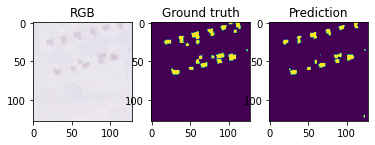

Confusion matrix :
[[15620    16]
 [  245   503]]
---
16384 pixels processed
Total accuracy : 98.406982421875%
---
F1Score :
No Buildings: 0.9917145487444843
Buildings: 0.7940015785319653
---
Kappa: 0.78599731039334
Confusion matrix :
[[78082    45]
 [ 1638  2155]]
---
81920 pixels processed
Total accuracy : 97.945556640625%
---
F1Score :
No Buildings: 0.9893377764544147
Buildings: 0.7191723677623895
---
Kappa: 0.7092899939391555
--------------Testing on patch number: 6----------------- 


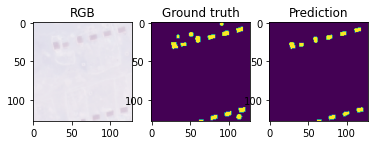

Confusion matrix :
[[15796     7]
 [  185   396]]
---
16384 pixels processed
Total accuracy : 98.828125%
---
F1Score :
No Buildings: 0.9939592247671785
Buildings: 0.8048780487804879
---
Kappa: 0.7990408577723803
Confusion matrix :
[[93878    52]
 [ 1823  2551]]
---
98304 pixels processed
Total accuracy : 98.0926513671875%
---
F1Score :
No Buildings: 0.9901123761410318
Buildings: 0.7312598538053605
---
Kappa: 0.7220311840112483
--------------Testing on patch number: 7----------------- 


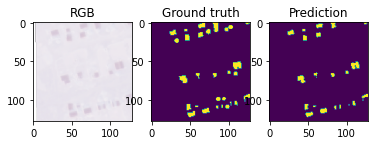

Confusion matrix :
[[15423    13]
 [  337   611]]
---
16384 pixels processed
Total accuracy : 97.86376953125%
---
F1Score :
No Buildings: 0.9887806128990896
Buildings: 0.77735368956743
---
Kappa: 0.7666338495517598
Confusion matrix :
[[109301     65]
 [  2160   3162]]
---
114688 pixels processed
Total accuracy : 98.05995396205358%
---
F1Score :
No Buildings: 0.9899242393366753
Buildings: 0.7397356415955082
---
Kappa: 0.7302869314849902
--------------Testing on patch number: 8----------------- 


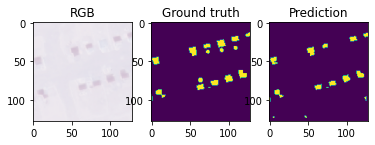

Confusion matrix :
[[15513    34]
 [  280   557]]
---
16384 pixels processed
Total accuracy : 98.08349609375%
---
F1Score :
No Buildings: 0.9899808551372048
Buildings: 0.7801120448179272
---
Kappa: 0.7704033620180963
Confusion matrix :
[[124814     99]
 [  2440   3719]]
---
131072 pixels processed
Total accuracy : 98.06289672851562%
---
F1Score :
No Buildings: 0.9899312757022132
Buildings: 0.7455146837726772
---
Kappa: 0.7360209808835617
--------------Testing on patch number: 9----------------- 


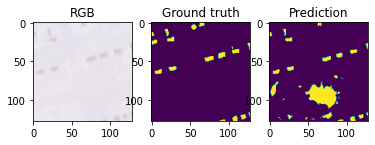

Confusion matrix :
[[14813  1005]
 [  157   409]]
---
16384 pixels processed
Total accuracy : 92.90771484375%
---
F1Score :
No Buildings: 0.9622580226062102
Buildings: 0.4131313131313131
---
Kappa: 0.38267151479432077
Confusion matrix :
[[139627   1104]
 [  2597   4128]]
---
147456 pixels processed
Total accuracy : 97.49009874131944%
---
F1Score :
No Buildings: 0.9869201816543267
Buildings: 0.6904741992138497
---
Kappa: 0.6776067864399368
--------------Overall Accuracy: ----------------- 
Mean accuracy in test set is: 98.20699890244366


[99.79248046875,
 98.7457275390625,
 97.84342447916667,
 97.8302001953125,
 97.945556640625,
 98.0926513671875,
 98.05995396205358,
 98.06289672851562,
 97.49009874131944]

In [30]:
test()

## Going back to SegNet with above prepared dataset

In [31]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self,in_channels, n_classes):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, n_classes, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x


In [32]:
# instantiate the network
net2 = SegNet(in_channels=4, n_classes=2)

We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [33]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net2.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to inc.double_conv.0.weight
Mapping features.0.bias to inc.double_conv.1.weight
Mapping features.1.weight to inc.double_conv.1.bias
Mapping features.1.bias to inc.double_conv.1.running_mean
Mapping features.1.running_mean to inc.double_conv.1.running_var
Mapping features.1.running_var to inc.double_conv.1.num_batches_tracked
Mapping features.3.weight to inc.double_conv.3.weight
Mapping features.3.bias to inc.double_conv.4.weight
Mapping features.4.weight to inc.double_conv.4.bias
Mapping features.4.bias to inc.double_conv.4.running_mean
Mapping features.4.running_mean to inc.double_conv.4.running_var
Mapping features.4.running_var to inc.double_conv.4.num_batches_tracked
Mapping features.7.weight to down1.maxpool_conv.1.double_conv.0.weight
Mapping features.7.bias to down1.maxpool_conv.1.double_conv.1.weight
Mapping features.8.weight to down1.maxpool_conv.1.double_conv.1.bias
Mapping features.8.bias to down1.maxpool_conv.1.double_conv.1.running_mean
Mapping fe

In [34]:
#loading the network on GPU
net2.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

In [42]:
from IPython.display import clear_output

def trainSegnet(net2, optimizer, epochs, scheduler=None, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    # weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net2(data)
            loss = CrossEntropy2d(output, target, weight=weights)
##            loss = F.cross_entropy(output, target, weight=weights)            
            loss.backward()
            optimizer.step()
            
            
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        #if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
        acc = test(net2, test_ids, all=False, stride=min(WINDOW_SIZE))
            #torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_finalData')



# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [44]:
base_lr = 0.01
params_dict2 = dict(net2.named_parameters())
params2 = []
for key2, value2 in params_dict2.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params2 += [{'params':[value2],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params2 += [{'params':[value2],'lr': base_lr / 2}]

optimizer2 = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer2, [25, 35, 45], gamma=0.1)

(128, 128) (128, 128)
Train (epoch 1/1) [700/720 (97%)]	Loss: 0.792437	Accuracy: 48.05908203125


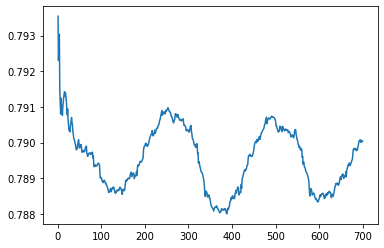

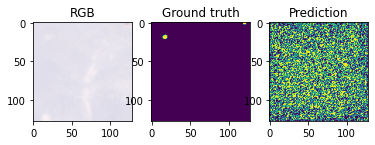

/tmp/ipykernel_271/3756619401.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.conv1_1_D(x))


In [45]:
train(net2, optimizer2, 1, scheduler2)